In [20]:
import numpy as np
import torch
from lib.models.models import UniformRate, UniformVariantRate
import ml_collections
from config.config_hollow import get_config
from lib.utils import utils
import torch.nn.functional as F
from lib.networks.unet import UNet
from lib.networks.hollow_networks import BidirectionalTransformer
from torch.utils.data import DataLoader
from lib.datasets.datasets import (
    create_train_discrete_mnist_dataloader,
    get_binmnist_datasets,
)
import matplotlib.pyplot as plt

"""
Now, when we minimize LCT, we are sampling (x, x ̃) from the forward process and then maximizing the assigned model probability for 

the pairing in the reverse direction, just as in LDT. The slight extra complexity comes from the fact we areconsidering the case 

when xk = xk+1 and the case when xk ̸= xk+1 separately. When xk = xk+1, this corresponds to the first term in LCT which we can see 

is minimizing the reverse rate out of x which is exactly maximizing the model probability for no transition to occur. When xk ̸= xk+1, 

this corresponds to the second term in LCT, which is maximizing the reverse rate from x ̃ to x which in turn maximizes the model probability 

for the x ̃ to x transition to occur.
"""


'\nNow, when we minimize LCT, we are sampling (x, x ̃) from the forward process and then maximizing the assigned model probability for \n\nthe pairing in the reverse direction, just as in LDT. The slight extra complexity comes from the fact we areconsidering the case \n\nwhen xk = xk+1 and the case when xk ̸= xk+1 separately. When xk = xk+1, this corresponds to the first term in LCT which we can see \n\nis minimizing the reverse rate out of x which is exactly maximizing the model probability for no transition to occur. When xk ̸= xk+1, \n\nthis corresponds to the second term in LCT, which is maximizing the reverse rate from x ̃ to x which in turn maximizes the model probability \n\nfor the x ̃ to x transition to occur.\n'

In [ ]:
cfg =  get_config()
cfg.model.t_func = "log_sqr"
cfg.model.rate_const = 0.01
dataloader = create_train_discrete_mnist_dataloader(
        batch_size=cfg.data.batch_size, image_size=cfg.data.image_size, use_augmentation=cfg.data.use_augm
    )
#train_set, _, _ = get_binmnist_datasets('/Users/paulheller/PythonRepositories/Master-Thesis/ContTimeDiscreteSpace/TAUnSDDM/lib/datasets/', device="cpu")
#dataloader = DataLoader(train_set, batch_size=cfg.data.batch_size, shuffle=True, num_workers=4)
model = UniformRate(cfg, 'cpu')
#model = UniformVariantRate(cfg, 'cpu')

In [ ]:
def plot_mnist_batch(batch, save_path=None):
    """Plottet ein Batch von MNIST-Bildern."""
    num_images = batch.shape[0]
    sqrt_num_images = int(np.sqrt(num_images))

    fig, axes = plt.subplots(sqrt_num_images, sqrt_num_images, figsize=(8, 8))

    for i, ax in enumerate(axes.flat):
        img = batch[i].squeeze()
        ax.imshow(img, cmap="gray")
        ax.axis("off") 

    plt.tight_layout() 
    #plt.savefig(save_path)
    plt.show()
    plt.close()

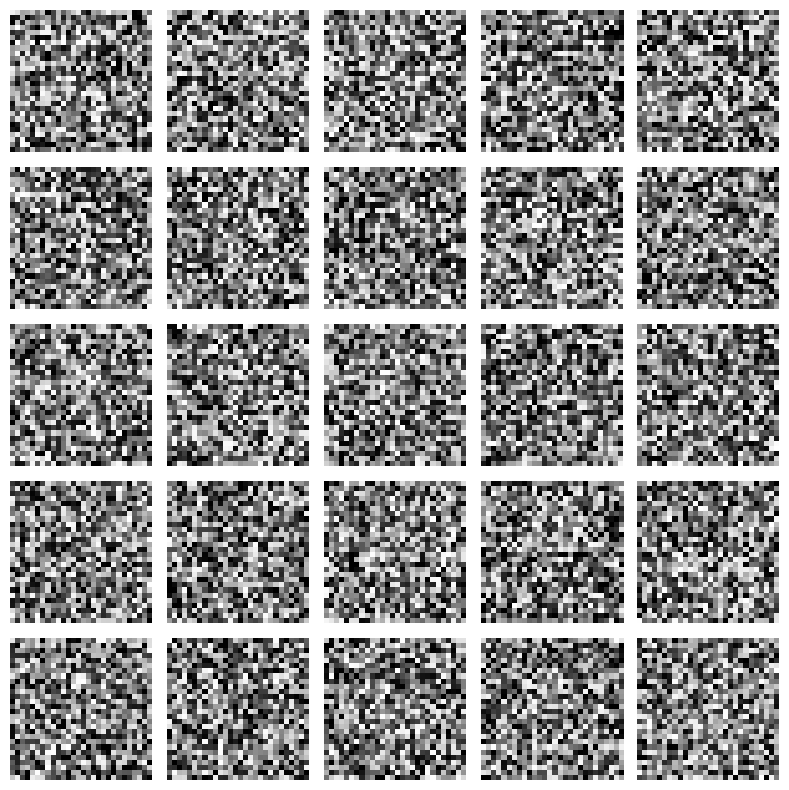

tensor(122.8661)
Mean: tensor(122.8661)
Std: tensor(79.5489)


In [25]:
i = 0
x_mean = 0 # 127.5
x_std = 0 # 73.7

for minibatch, _ in dataloader:
    
    B, C, H, W = minibatch.shape
    minibatch = minibatch.view(B, C * H * W) 
    # hollow xt, t, l_all, l_xt geht rein
    device = cfg.device
    ts = torch.rand((B,), device=device) * (1.0 - 0.01) + 0.0
    ts = torch.ones((B, )) 
    qt0 = model.transition(ts)  # (B, S, S)

    # rate = model.rate(ts)  # (B, S, S)

    b = utils.expand_dims(torch.arange(B), (tuple(range(1, minibatch.dim()))))
    qt0 = qt0[b, minibatch.long()]

    # log loss
    log_qt0 = torch.where(qt0 <= 0.0, -1e9, torch.log(qt0))
    xt = torch.distributions.categorical.Categorical(logits=log_qt0).sample()
    xt = xt.view(B, C, H, W) 
    #print(type(xt))
    plot_mnist_batch(xt)

    print(torch.mean(xt[0,:, :, :].float()))
    x_mean +=torch.mean(xt[0,:, :, :].float())
    x_std += torch.std(xt[0,:, :, :].float())
    i = i+1
    print("Mean:", x_mean / i)
    print("Std:", x_std / i)
    break

In [45]:
        # if 4 Dim => like images: True
i = 0
x_mean_t = 0
for minibatch, _ in dataloader:
    B, C, H, W = minibatch.shape
    minibatch = minibatch.view(B, C * H * W)

    B, D = minibatch.shape
    device = model.device

    # get random timestep between 1.0 and self.min_time
    ts = torch.rand((B,), device=device) * (1.0 - 0.01) + 0.01

    qt0 = model.transition(
        ts
    )  # (B, S, S) # transition q_{t | s=0} eq.15 => here randomness because of ts => for every ts another q_{t|0}

    # R_t = beta_t * R_b
    rate = model.rate(
        ts
    )  # (B, S, S) # no proability in here (diagonal = - sum of rows)

    # --------------- Sampling x_t, x_tilde --------------------
    # qt0_rows_reg = (B * D, S) probability distribution
    # diagonal elements of qt0 (higher probability) will be put at column of value of x_t
    # we do this because then we sample from qt0_rows_reg and then it is most likely more similar to x0=batch
    # example: q_t0 =   [0.4079, 0.2961, 0.2961],
    #                   [0.2961, 0.4079, 0.2961],
    #                   [0.2961, 0.2961, 0.4079]],
    # batch = (2, 0, 1)
    # qt0_rows_reg = [0.2961, 0.2961, 0.4079],
    #                [0.4079, 0.2961, 0.4079],
    #                [0.2961, 0.4079, 0.2961]

    qt0_rows_reg = qt0[
        torch.arange(B, device=device).repeat_interleave(
            D
        ),  # repeats every element 0 to B-1 D-times
        minibatch.flatten().long(),  # minibatch.flatten() => (B, D) => (B*D) (1D-Tensor)
        :,
    ]  # (B*D, S)

    # set of (B*D) categorical distributions with probabilities from qt0_rows_reg
    x_t_cat = torch.distributions.categorical.Categorical(qt0_rows_reg)
    x_t = x_t_cat.sample().view(  # sampling B * D times => from every row of qt0_rows_reg once => then transform it to shape B, D
        B, D
    )  # (B*D,) mit view => (B, D) Bsp: x_t = (0, 1, 2, 4, 3) (for B =1 )
    #print(torch.mean(x_t[0, :].float()))
    x_mean_t +=torch.mean(x_t[0,:].float())
    i = i+1
    print("overall", x_mean_t / i)


    


overall tensor(129.9031)
overall tensor(129.8731)
overall tensor(129.4154)
overall tensor(127.7149)
overall tensor(127.5316)
overall tensor(127.7532)
overall tensor(127.4016)
overall tensor(127.5756)
overall tensor(128.0835)
overall tensor(128.1330)
overall tensor(127.8340)
overall tensor(127.8485)
overall tensor(127.5180)
overall tensor(127.5259)
overall tensor(127.7029)
overall tensor(127.6688)
overall tensor(127.5735)
overall tensor(127.5109)
overall tensor(127.5726)
overall tensor(127.6734)
overall tensor(127.7119)
overall tensor(127.7330)
overall tensor(127.8131)
overall tensor(127.9375)
overall tensor(127.6839)
overall tensor(127.6849)
overall tensor(127.8428)
overall tensor(127.6692)
overall tensor(127.8840)
overall tensor(127.9300)
overall tensor(127.8764)
overall tensor(127.9904)
overall tensor(128.0751)
overall tensor(128.0299)
overall tensor(128.0891)
overall tensor(128.1724)
overall tensor(128.0675)
overall tensor(128.0328)
overall tensor(128.0071)


KeyboardInterrupt: 

In [ ]:
import torch
B = 2
D = 4
S = 3
log_prob = torch.rand((B,D, S))
print(log_prob)
x = torch.randint(low=0, high=3, size=(B, 1), device='cpu')
one_hot = F.one_hot(x)
print(one_hot,one_hot.shape)
mult = log_prob * one_hot
print(mult, mult.shape)
sum_mult = torch.sum(mult, dim=-1)
print(sum_mult, sum_mult.shape)

print(torch.sum(sum_mult))

In [ ]:
config =  get_config()
bdt = BidirectionalTransformer(config)
print("number of parameters: ", sum([p.numel() for p in bdt.parameters()]))
B = config.data.batch_size
D = config.concat_dim
S = config.data.S
xt= torch.randint(low=0, high=S, size=(B, D), dtype=torch.int)
t = 1 * torch.ones((B, ))
print(len(t.shape))
# x_pred = bdt(xt, t)
#print(x_pred.shape)

In [ ]:
config =  get_config()
model = UniformRate(config, 'cpu')
S = 256
B = 32
D = 1024
y = torch.randint(low=0, high=S, size=(B, D), dtype=torch.int)
t = 1 * torch.ones((B, ))
rate = model.rate_mat(y, t)
print(rate.shape)
    

In [ ]:
import time
S=256
rate_const = 1


cfg.data.S = S
device = 'cpu'
cfg.model.rate_const = rate_const

S = 256
B = 64
D = 1024
model = UniformRate(cfg, 'cpu')
unet = UNet(
                in_channel=1,
                out_channel=1,
                channel=32,
                channel_multiplier=cfg.model.ch_mult,
                n_res_blocks=cfg.model.num_res_blocks,
                attn_resolutions=[16],
                num_heads=1,
                dropout=cfg.model.dropout,
                model_output = 'logits',  # 'logits' or 'logistic_pars'
                num_classes=S,
                x_min_max=(0, 255),
                img_size=32,
        )
t = 1
xt= torch.randint(low=0, high=S, size=(B, D), dtype=torch.int)
B, D = xt.shape
C, H, W = (1, 32, 32)
S = 256
x = xt.view(B, C, H, W)
x_pred = unet(x, t * torch.ones((B,), device=device))
x_pred = x_pred.view(B, D, S)
print("PRED",x_pred, x_pred.shape)
log_p0t = F.log_softmax(x_pred, dim=2)
print(log_p0t, log_p0t.shape)



In [ ]:
import math
def transformer_timestep_embedding(timesteps, embedding_dim, max_positions=10000):
    assert embedding_dim % 2 == 0
    assert len(timesteps.shape) == 1
    half_dim = embedding_dim // 2
    emb = math.log(max_positions) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb

In [ ]:
import torch.nn as nn
x = torch.randint(0, S, (B, D))  # Zufällige Integer zwischen 0 und vocab_size - 1

# Embedding-Layer
embedding = nn.Embedding(S, 10)
x = embedding(x)
print(x.shape)

In [ ]:
import torch.nn as nn
x = torch.randint(0, S, (B, D))  # Zufällige Integer zwischen 0 und vocab_size - 1

# Embedding-Layer
embedding = nn.Embedding(S, 10)
x = embedding(x)
print(x.shape)

t =1 * torch.ones((B,))
temb = transformer_timestep_embedding(t, 10, max_positions=10000)

assert x.ndim == 3 and temb.ndim == 2 # B, D, E and B, E
print(temb.shape)
temb = temb.unsqueeze(1)
print(temb.shape)
conditioner = temb

#conditioner = torch.cat([conditioner, temb], dim=1) # B, 2D, E
print(conditioner.shape)
cond_dim = conditioner.size(1) # 2D
print("cond_dim", cond_dim)
concat_dim = x.size(1) + cond_dim - 1 # 3D -1
print("conc dim", concat_dim)
pos_idx = torch.arange(concat_dim, dtype=torch.int32).unsqueeze(0)
print("pos", pos_idx.shape)
print("x[:, :-1]", x[:, :-1].shape)
x = torch.cat([conditioner, x[:, :-1]], dim=1)
print("conditioner", conditioner.shape)
print("x", x.shape)
mask = pos_idx.unsqueeze(-1) <= pos_idx.unsqueeze(-2)
mask = mask.unsqueeze(-3) 
print("mask", mask, mask.shape)
mask = mask[:, :, -cond_dim:, -cond_dim:] = 1.0
print("mask", mask, mask.shape)
#attn_mask = torch.triu(torch.ones((concat_dim, concat_dim)), diagonal=1).bool()
attn_mask = torch.tril(torch.ones(concat_dim, concat_dim), diagonal=1).bool()
print("mask", mask, mask.shape)
print(mask.squeeze(0).squeeze(0) == ~attn_mask)


In [ ]:
attn_mask = torch.triu(torch.ones((5, 5)), diagonal=1).bool()
print(attn_mask)



In [ ]:
attn_mask = torch.tril(torch.ones(5, 5), diagonal=-1).bool()
print(attn_mask)
#print(attn_mask)

In [ ]:
qt_test = model.transition
print(qt_test.shape)
qt_test = utils.expand_dims(qt_test, axis=list(range(1, xt.dim() - 1)))
print(qt_test.shape)
torch.where(qt_test <= 1e-35, -1e9, torch.log(qt_test))

In [ ]:
h = 0.01
start_opt = time.time()
t_eps = t - h #tau
q_teps_0 = model.transition(t_eps * torch.ones((B,), device=device)) # (N, S, S)
print(q_teps_0)
q_teps_0 = utils.expand_dims(q_teps_0, axis=list(range(1, xt.ndim)))


q_t_teps = model.transit_between(t_eps * torch.ones((B,), device=device), t * torch.ones((B,), device=device))  # (N, S, S
print(q_t_teps)
q_t_teps = q_t_teps.permute(0, 2, 1)
b = utils.expand_dims(torch.arange(xt.shape[0]), axis=list(range(1, xt.ndim)))
q_t_teps = q_t_teps[b, xt.long()].unsqueeze(-2)
print("q_teps_0", q_teps_0, q_teps_0.shape)
print("q_t_teps", q_t_teps, q_t_teps.shape)
start_opt = time.time()
qt0 = q_teps_0 * q_t_teps 
print("qt0", qt0, qt0.shape)

end_opt = time.time()



In [ ]:
# print((qt0 >= 0).all())
print(torch.log(qt0))

In [ ]:
a = torch.where(q_teps_0 <= 0.0, -1e9, torch.log(q_teps_0))
b = torch.where(q_t_teps <= 0.0, -1e9, torch.log(q_t_teps))
c = a + b

In [ ]:
b = utils.expand_dims(torch.arange(xt.shape[0]), axis=list(range(1, xt.ndim)))
q_t_teps = q_t_teps[b, xt.long()].unsqueeze(-2)
qt0 = q_teps_0 * q_t_teps # 30-60sekunden

log_qt0 = torch.where(qt0 <= 0.0, -1e9, torch.log(qt0)) # 7min
start_opt = time.time()
log_p0t = log_p0t.unsqueeze(-1)
log_prob = torch.logsumexp(log_p0t + log_qt0, dim=-2)
end_opt = time.time()
print(end_opt - start_opt)


In [ ]:
print(log_qt0, log_qt0.shape)
print(c, c.shape)
print(c == log_qt0)

In [ ]:

log_p0t = log_p0t.unsqueeze(-1)
log_prob = torch.logsumexp(log_p0t + log_qt0, dim=-2)
# axis kein parameter? fehler hier
end_opt = time.time()
print("sampling operations time", end_opt - start_opt)
q_teps_0 = model.transition(t_eps * torch.ones((B,), device=device)) # (N, S, S)
print(q_teps_0, q_teps_0.shape)
q_teps_0 = utils.expand_dims(q_teps_0, axis=list(range(1, xt.ndim)))
print(q_teps_0, q_teps_0.shape)
q_t_teps = model.transit_between(t_eps * torch.ones((B,), device=device), t * torch.ones((B,), device=device))  # (N, S, S
print(q_t_teps, q_t_teps.shape)
q_t_teps = q_t_teps.permute(0, 2, 1)
print(q_t_teps, q_t_teps.shape)

In [ ]:
b = utils.expand_dims(torch.arange(xt.shape[0]), axis=list(range(1, xt.ndim)))
print(b, b.shape)
q_t_teps = q_t_teps[b, xt].unsqueeze(-2)
print(q_t_teps, q_t_teps.shape)

In [ ]:
#-----------Transition matrix q_t|0: x0 -> xt ---------------------
cfg = get_config()
cfg.data.S = S
cfg.model.rate_const = rate_const
uni = UniformRate(cfg, 'cpu')
ts = torch.rand((B,))
qt0 = uni.transition(ts)
x0= torch.randint(low=0, high=S, size=(B, D), dtype=torch.int)
#print(x0)
#print(qt0, qt0.shape)
qt0_rows_reg = qt0[
    torch.arange(B, device=device).repeat_interleave(
        D
    ),  # repeats every element 0 to B-1 D-times
    x0.flatten().long(),  # minibatch.flatten() => (B, D) => (B*D) (1D-Tensor)
    :,
]
print(qt0_rows_reg, qt0_rows_reg.shape)
b = utils.expand_dims(torch.arange(B), (tuple(range(1, x0.dim()))))
qt0_rows_reg2 = qt0[b, x0] #.view(-1, S)

logits = torch.where(qt0 <= 0.0, -1e9, torch.log(qt0_rows_reg2))


x_t_cat = torch.distributions.categorical.Categorical(qt0_rows_reg)
x_t = x_t_cat.sample().view(B, D)
print(x_t, x_t.shape)

In [ ]:
#-------------- Transition rate: x_t -> x_tilde ------------------
rate = uni.rate(ts)
#print(rate, rate.shape) # B, S, S
rate_vals_square = rate[
        torch.arange(B, device=device).repeat_interleave(D), x_t.long().flatten(), :
    ]
#print(rate_vals_square, rate_vals_square.shape)
rate_vals_square[
        torch.arange(B * D, device=device), x_t.long().flatten()
    ] = 0.0 
print(rate_vals_square, rate_vals_square.shape)

rate_vals_square = rate_vals_square.view(B, D, S)
print(rate_vals_square, rate_vals_square.shape)

rate_vals_square_dimsum = torch.sum(rate_vals_square, dim=2).view(B, D)
print(rate_vals_square_dimsum, rate_vals_square_dimsum.shape)

square_dimcat = torch.distributions.categorical.Categorical(rate_vals_square_dimsum)

square_dims = square_dimcat.sample() # sampled where transition takes places in every row of B
print("Where transition", square_dims, square_dims.shape)

rate_new_val_probs = rate_vals_square[
    torch.arange(B, device=device), square_dims, :
]  # (B, S)
print(rate_new_val_probs, rate_new_val_probs.shape)

square_newvalcat = torch.distributions.categorical.Categorical(
    rate_new_val_probs
)

# Shape: (B,) mit Werten im Bereich [0, S)
square_newval_samples = (
    square_newvalcat.sample()
)
print("Transition value", square_newval_samples, square_newval_samples.shape)

x_tilde = x_t.clone()
        # noisy image 
x_tilde[torch.arange(B, device=device), square_dims] = square_newval_samples
print(x_t)
print(x_tilde)


In [ ]:
#-----------ELBO-------------------
mask_reg = torch.ones((B, D, S), device=device)

mask_reg[
    torch.arange(B, device=device).repeat_interleave(D),
    torch.arange(D, device=device).repeat(B),
    x_tilde.long().flatten(),
] = 0.0
print(x_tilde)
print(mask_reg, mask_reg.shape)

In [ ]:
qt0_numer_reg = qt0.view(B, S, S)
print(qt0_numer_reg , qt0_numer_reg.shape)
# q_{t|0} (x|x_0)
qt0_denom_reg = (
    qt0[
        torch.arange(B, device=device).repeat_interleave(D),
        :,
        x_tilde.long().flatten(),
    ].view(B, D, S)
    + 1e-6
)
#print(qt0_denom_reg, qt0_denom_reg.shape)

#print(rate, rate.shape)
rate_vals_reg = rate[
    torch.arange(B, device=device).repeat_interleave(D),
    :,
    x_tilde.long().flatten(),
].view(B, D, S)
print(rate_vals_reg, rate_vals_reg.shape)
print((mask_reg * rate_vals_reg))
reg_tmp = (mask_reg * rate_vals_reg) @ qt0_numer_reg.transpose(1, 2)
print(reg_tmp, reg_tmp.shape)

In [ ]:
rate_const = 1
S = 3
B = 2
D = 4
cfg = get_config()
cfg.data.S = S
cfg.model.rate_const = rate_const
uni = UniformRate(cfg, 'cpu')
ts = torch.rand((B,))
xt= torch.randint(low=0, high=S, size=(B, D), dtype=torch.int)
print(xt)

qt0 = uni.transition(ts)

qt0_y2x = qt0.permute(0, 2, 1)
print(qt0, qt0.shape)
print(qt0_y2x, qt0_y2x.shape)
print(qt0 == qt0_y2x)

In [ ]:
b = utils.expand_dims(
    torch.arange(xt.shape[0]), tuple(range(1, xt.dim()))
)
print(b, b.shape)
qt0_y2x = qt0_y2x[b, xt]
print(qt0_y2x, qt0_y2x.shape)

In [ ]:
logits = qt0_y2x
log_p0t = F.log_softmax(logits, dim=-1)
print(log_p0t, log_p0t.shape)
log_qt0 = torch.where(qt0 <= 1e-35, -1e9, torch.log(qt0))
print(log_qt0, log_qt0.shape)
log_qt0 = utils.expand_dims(log_qt0, axis=list(range(1, xt.dim())))
print(log_qt0, log_qt0.shape)
log_p0t = log_p0t.unsqueeze(-1)
print(log_p0t, log_p0t.shape)
log_prob = torch.logsumexp(log_p0t + log_qt0, dim=-2)
print(log_prob, log_prob.shape)


In [ ]:
xt_onehot = F.one_hot(xt.long(), S)
qt0 = uni.transition(ts)
p0t = F.softmax(logits, dim=-1)
print(p0t, p0t.shape)
qt0 = utils.expand_dims(qt0, axis=list(range(1, xt.dim() - 1)))
print(qt0, qt0.shape)
prob_all = p0t @ qt0
print(prob_all.shape)
log_prob = torch.log(prob_all + 1e-35)
print(log_prob, log_prob.shape)
log_xt = torch.sum(log_prob * xt_onehot, axis=-1)
print(log_xt, log_xt.shape)

In [ ]:
qt0 = uni.transition(ts)
t_eps = ts - 0.1
q_t_teps = uni.transit_between(t_eps * torch.ones((B,), device=device), ts * torch.ones((B,), device=device))
print(q_t_teps, q_t_teps.shape, qt0.shape)
b = utils.expand_dims(torch.arange(B), (tuple(range(1, x0.dim()))))
qt0_rows_reg2 = qt0[b, x0]
print(qt0_rows_reg2, qt0_rows_reg2.shape)
logits = torch.where(qt0_rows_reg2  <= 0.0, -1e9, torch.log(qt0_rows_reg2))
print(logits, logits.shape)

x_t_cat = torch.distributions.categorical.Categorical(logits).sample()
print(x_t_cat,x_t_cat.shape)

In [ ]:
ll_xt = xt #B, D
ll_all =  logits# B, D, S
loss = -(
    (S - 1) * ll_xt
    + torch.sum(utils.log1mexp(ll_all), dim=-1)
    - utils.log1mexp(ll_xt)
)
print(loss, loss.shape)
weight = torch.ones((B,), dtype=torch.float32)
weight = utils.expand_dims(weight, axis=list(range(1, loss.dim())))
print(weight, weight.shape)
loss = loss * weight
print(loss, loss.shape)
loss = torch.sum(loss) / xt.shape[0]
print(loss, loss.shape)

In [ ]:
ll_xt = xt #B, D
ll_all =  logits
xt_onehot = F.one_hot(xt.long(), num_classes=S)
b = utils.expand_dims(torch.arange(xt.shape[0]), tuple(range(1, xt.dim())))
print(b, b.shape)
qt0_x2y = uni.transition(ts)
print(qt0_x2y, qt0_x2y.shape)
qt0_y2x = qt0_x2y.permute(0, 2, 1)
print(qt0_x2y, qt0_x2y.shape)
qt0_y2x = qt0_y2x[b, xt]
print(qt0_x2y, qt0_x2y.shape)
ll_xt = ll_xt.unsqueeze(-1)
print("ll", ll_xt, ll_xt.shape)
backwd = torch.exp(ll_all - ll_xt) * qt0_y2x
print(backwd , backwd.shape)


In [ ]:
first_term = torch.sum(backwd * (1 - xt_onehot), dim=-1)
print(first_term , first_term.shape)
qt0_x2y = qt0_x2y[b, xt]
print(qt0_x2y, qt0_x2y.shape)
fwd = (ll_xt - ll_all) * qt0_x2y
print(fwd, fwd.shape)
second_term = torch.sum(fwd * (1 - xt_onehot), dim=-1)
print(second_term, second_term.shape)
loss = first_term - second_term
print(loss, loss.shape)

In [ ]:
weight = torch.ones((B,), dtype=torch.float32)
weight = utils.expand_dims(weight, axis=list(range(1, loss.dim())))
print(weight, weight.shape)
loss = loss * weight
print(loss, loss.shape)
loss = torch.sum(loss) / xt.shape[0]
print(loss, loss.shape)

In [ ]:
ts = np.concatenate((np.linspace(1.0, 1e-3, 1000), np.array([0])))
#save_ts = ts[np.linspace(0, len(ts)-2, num_intermediates, dtype=int)]

for idx, t in (enumerate(ts[0:-1])):
    print(t)